In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import re

In [2]:
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [3]:
from trainlib.ConfigFileHandler import ConfigFileHandler
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.ConfigFileUtils import ConfigFileUtils

Welcome to JupyROOT 6.10/09


Using TensorFlow backend.


In [4]:
campaign_workspace = "/data_CMS/cms/wind/"

In [10]:
def make_comparison_plot(campaign_workspace, campaign_names, campaign_labels):
    df_loss = pd.DataFrame()
    df_H1_length = pd.DataFrame()
    df_H0_length = pd.DataFrame()
    
    for campaign_name in campaign_names:
        campaign_dir = campaign_workspace + campaign_name + "/"

        folder, subs, files = os.walk(campaign_dir).next()
        for sub in subs:
            if "bin" not in sub and "statistics" not in sub:
                config_file = os.path.join(folder, sub, "model_benchmark.txt")

                try:
                    values_loss = {}
                    values_H1_length = {}
                    values_H0_length = {}

                    values_loss["campaign"] = campaign_name
                    values_H1_length["campaign"] = campaign_name
                    values_H0_length["campaign"] = campaign_name

                    confhandler = ConfigFileHandler()
                    confhandler.load_configuration(config_file)

                    # now look at all of the sections 
                    models = confhandler.get_sections()
                    for model in models:
                        values_loss[model] = float(confhandler.get_field(model, 'val_loss'))
                        values_H1_length[model] = int(confhandler.get_field(model, 'H1_val_length'))
                        values_H0_length[model] = int(confhandler.get_field(model, 'H0_val_length'))

                    df_loss = df_loss.append(pd.DataFrame(values_loss, index = [len(df_loss)]))
                    df_H1_length = df_H1_length.append(pd.DataFrame(values_H1_length, index = [len(df_H1_length)]))
                    df_H0_length = df_H0_length.append(pd.DataFrame(values_H0_length, index = [len(df_H0_length)]))

                except IOError:
                    print("ignoring non-existing file " + config_file)
    
    fig = plt.figure(figsize = (15, 5))
    
    print df_loss
    
    if len(df_loss) > 0:
        df_loss.fillna(10.0)
        # condense all the different loss values into one global loss estimate (if such a thing can reasonably be done)
        # each loss value is already an average over its specific training dataset -> compute the global average by first undoing all the local ones
        loss_averages = df_loss[models].as_matrix()
        dataset_lengths = df_H1_length[models].as_matrix() + df_H0_length[models].as_matrix()
        global_losses = np.sum(np.multiply(loss_averages, dataset_lengths), axis = 1)
        global_losses = np.expand_dims(global_losses, axis = 1)

        loss_data = df_loss[models].as_matrix()
        loss_data = np.concatenate([loss_data, global_losses], axis = 1)
        loss_data = np.divide(loss_data, loss_data[0])
        loss_data_columns = np.concatenate([[''], df_loss[models].columns, ['global']])
        loss_data_rows = np.concatenate([[''], df_loss['campaign'].as_matrix()])

        ax = fig.add_subplot(111)
        cax = ax.matshow(loss_data, cmap = 'RdYlGn_r', vmin = 0.9, vmax = 1.1, aspect = 3.0)
        fig.colorbar(cax)
        #ax.set_yticklabels(loss_data_rows)
        ax.set_yticklabels([''] + campaign_labels)
        ax.set_xticklabels(loss_data_columns, rotation = 'vertical')

        for y, gloss in enumerate(loss_data[:,-1]):
            print gloss
            ax.text(len(loss_data_columns) - 2, y, "{:4.3f}".format(gloss), va = 'center', ha = 'center', rotation = 'vertical')

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    return fig

In [6]:
%%capture
plot_17 = make_comparison_plot(campaign_workspace, ["180417_Adam_optimized_inputs_128", 
                                                    "180417_Adam_optimized_inputs_64",
                                                    "180418_Adam_optimized_64_deep",
                                                    "180418_Adam_optimized_32",
                                                    "180418_Adam_optimized_32_deep",
                                                    "180419_Adam_Hdecay_variables_128",
                                                    "180419_Adam_Hdecay_variables_64"],
                                                   ["128 hidden neurons, 3 hidden layers",
                                                    "64 hidden neurons, 3 hidden layers",
                                                    "64 hidden neurons, 5 hidden layers",
                                                    "32 hidden neurons, 3 hidden layers",
                                                    "32 hidden neurons, 5 hidden layers",
                                                    "128 hidden neurons, H decay variables",
                                                    "64 hidden neurons, H decay variables"])

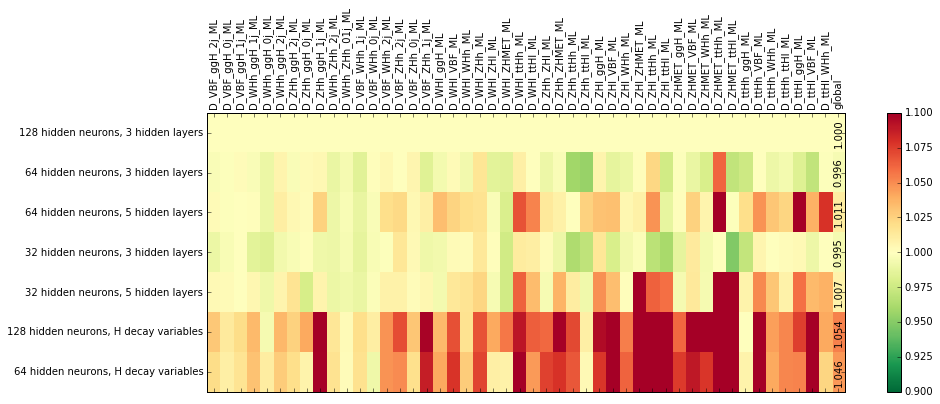

In [7]:
plt.show()

In [14]:
%%capture
plot_23 = make_comparison_plot(campaign_workspace, ["180423_dynamic_modelcoll_validation",
                                                    "180423_optimized_inputs_64",
                                                    "180423_optimized_inputs_dynamic_64"],
                                                   ["64 hidden neurons, automatic variable selection",
                                                    "64 hidden neurons, manual variable selection",
                                                    "64 hidden neurons, automatic extended variable selection"])

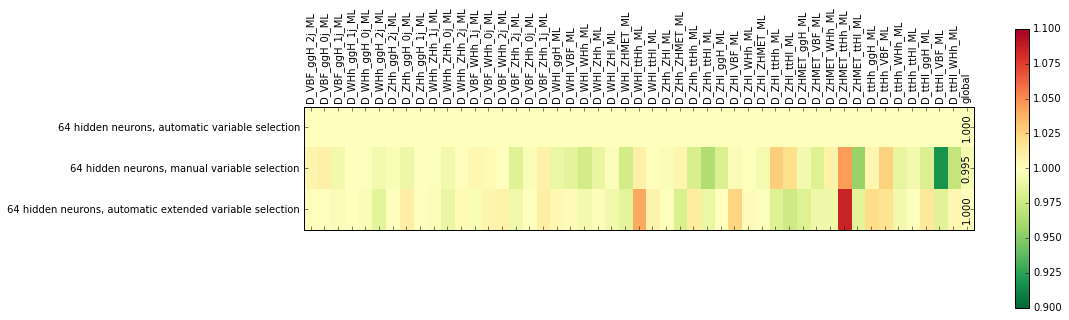

In [15]:
plt.show()